# **JSON Data Parsing and Visualization**

## **Install Required Packages**

In [4]:
!pip install pandas pyarrow fastparquet

## **Import Required Libraries**

In [5]:
import json
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlparse

# **Download JSON File from URL**

In [6]:
# Function for downloading JSON file via URL
def download_file(url, dest_base, identifier):
    """Download a file from a URL"""
    os.makedirs(os.path.dirname(dest_base), exist_ok=True)
    url_parts = urlparse(url).path.split('/')
    filename = url_parts[-1]
    model_name = url_parts[-3]
    filename = f"{filename.split('.')[0]}_{model_name}_{identifier}.json"
    dest = os.path.join(dest_base, filename)

    if not os.path.exists(dest):
        print(f"Downloading {url} to {dest}")
        response = requests.get(url)
        response.raise_for_status()
        with open(dest, 'wb') as file:
            file.write(response.content)
    else:
        print(f"File already exists at {dest}")

    return dest

# **Parse JSON Results into DataFrame**

In [7]:
# Function to parse results into a DataFrame
def parse_results_to_df(input_files):
    """Parse JSON results into a pandas DataFrame."""
    data = []
    for file_path in input_files:
        try:
            with open(file_path, 'r') as file:
                json_data = json.load(file)
                results = json_data.get("results", {})

                for key, value in results.items():
                    row = {
                        "benchmark": key,
                        "acc_norm": value.get("acc_norm,none"),
                        "acc_norm_stderr": value.get("acc_norm_stderr,none"),
                    }
                    data.append(row)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    return pd.DataFrame(data)

# **Save DataFrame as CSV or Parquet**

In [8]:
# Function to save DataFrame to CSV or Parquet
def save_results(df, output_format='csv'):
    """Save DataFrame to CSV or Parquet format."""
    os.makedirs('./output/', exist_ok=True)
    if output_format == 'csv':
        output_file = './output/results.csv'
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    elif output_format == 'parquet':
        output_file = './output/results.parquet'
        df.to_parquet(output_file, index=False)
        print(f"Data saved to {output_file}")
    else:
        print(f"Unsupported output format: {output_format}")

# **Function to Plot Results**

In [9]:
# Function to plot results
def plot_results(df, model_name):
    """Plot the results for given DataFrame."""
    # List of language codes the Aya model was trained on
    trained_language_codes = ['ar', 'zh', 'cs', 'nl', 'en', 'fr', 'de', 'el', 'he', 'hi', 'id', 'it',
                              'ja', 'ko', 'fa', 'pl', 'pt', 'ro', 'ru', 'es', 'tr', 'uk', 'vi']

    # Mapping of language codes to full names
    language_names = {
        'ar': 'Arabic', 'zh': 'Chinese', 'cs': 'Czech', 'nl': 'Dutch', 'en': 'English', 'fr': 'French',
        'de': 'German', 'el': 'Greek', 'he': 'Hebrew', 'hi': 'Hindi', 'id': 'Indonesian', 'it': 'Italian',
        'ja': 'Japanese', 'ko': 'Korean', 'fa': 'Persian', 'pl': 'Polish', 'pt': 'Portuguese', 'ro': 'Romanian',
        'ru': 'Russian', 'es': 'Spanish', 'tr': 'Turkish', 'uk': 'Ukrainian', 'vi': 'Vietnamese',
        'te': 'Telugu', 'ta': 'Tamil', 'sv': 'Swedish', 'sr': 'Serbian', 'sk': 'Slovak',
        'ne': 'Nepali', 'mr': 'Marathi', 'ml': 'Malayalam', 'kn': 'Kannada', 'hy': 'Armenian',
        'hu': 'Hungarian', 'hr': 'Croatian', 'gu': 'Gujarati', 'eu': 'Basque', 'da': 'Danish',
        'ca': 'Catalan', 'bn': 'Bengali'
    }

    # Splitting the data into trained/seen and untrained/unseen categories based on the language codes
    df['language_code'] = df['benchmark'].apply(lambda x: x.split('_')[1] if '_' in x else 'en')
    df['trained'] = df['language_code'].apply(lambda x: x in trained_language_codes)
    df['language_name'] = df['language_code'].map(language_names).fillna('Unknown')

    # Separating the data - trained/seen and untrained/unseen
    trained_df = df[df['trained']]
    untrained_df = df[~df['trained']]

    # Defining colors
    colors = {
        'trained_non_chat': '#1f77b4',
        'trained_chat': '#ff7f0e',
        'untrained_non_chat': '#2ca02c',
        'untrained_chat': '#d62728'
    }

    fig, ax = plt.subplots(figsize=(20, 10))
    bar_width = 0.80

    # Plot for trained/seen languages
    index_trained = np.arange(len(trained_df)) * 2

    ax.bar(index_trained, trained_df['acc_norm_non_chat'], bar_width,
           yerr=trained_df['acc_norm_stderr_non_chat'], label='Non-Chat (Seen)',
           alpha=0.7, color=colors['trained_non_chat'], capsize=5)
    ax.bar(index_trained + bar_width, trained_df['acc_norm_chat'], bar_width,
           yerr=trained_df['acc_norm_stderr_chat'], label='Chat (Seen)',
           alpha=0.7, color=colors['trained_chat'], capsize=5)

    # Plot for untrained/unseen languages
    index_untrained = np.arange(len(untrained_df)) * 2 + (len(trained_df) * 2) + 3

    ax.bar(index_untrained, untrained_df['acc_norm_non_chat'], bar_width,
           yerr=untrained_df['acc_norm_stderr_non_chat'], label='Non-Chat Template (Unseen)',
           alpha=0.7, color=colors['untrained_non_chat'], capsize=5)
    ax.bar(index_untrained + bar_width, untrained_df['acc_norm_chat'], bar_width,
           yerr=untrained_df['acc_norm_stderr_chat'], label='Chat (Unseen)',
           alpha=0.7, color=colors['untrained_chat'], capsize=5)

    # Adding a red vertical line to separate trained/seen and untrained/unseen languages
    plt.axvline(x=(len(trained_df) * 2) + 2, color='red', linestyle='--', linewidth=4)

    # Setting labels and title with adjusted padding
    ax.set_xlabel('Languages')
    ax.set_ylabel('Normalized Accuracy (%)')
    ax.set_title(f'Normalized Accuracy Across Different Languages: With and Without Chat Templates\n{model_name}', pad=40)
    ax.set_xticks(np.concatenate((index_trained, index_untrained)) + bar_width / 2)
    ax.set_xticklabels(list(trained_df['language_name']) + list(untrained_df['language_name']), rotation=45, ha='right')

    # Adding section labels inside the graph
    plt.text(len(trained_df) * 0.9, max(df['acc_norm_non_chat'].max(), df['acc_norm_chat'].max()) * 1.02,
             'Languages seen during Pre-training', ha='center', va='center', fontsize=12, color='black')
    plt.text((len(trained_df) + len(untrained_df)) * 1.4, max(df['acc_norm_non_chat'].max(), df['acc_norm_chat'].max()) * 1.02,
             'Other Languages', ha='center', va='center', fontsize=12, color='black')

    # Adding legend with labels
    ax.legend()

    plt.tight_layout()
    plt.show()

# **Main Execution Block**

File already exists at ./input/results_2024-08-04T14-52-52_aya-23-8b-hellaswag_with_okapi_without_template_no_template.json
File already exists at ./input/results_2024-08-04T22-30-16_aya-23-8b-hellaswag_with_okapi_with_template_with_template.json
Data saved to ./output/results.csv


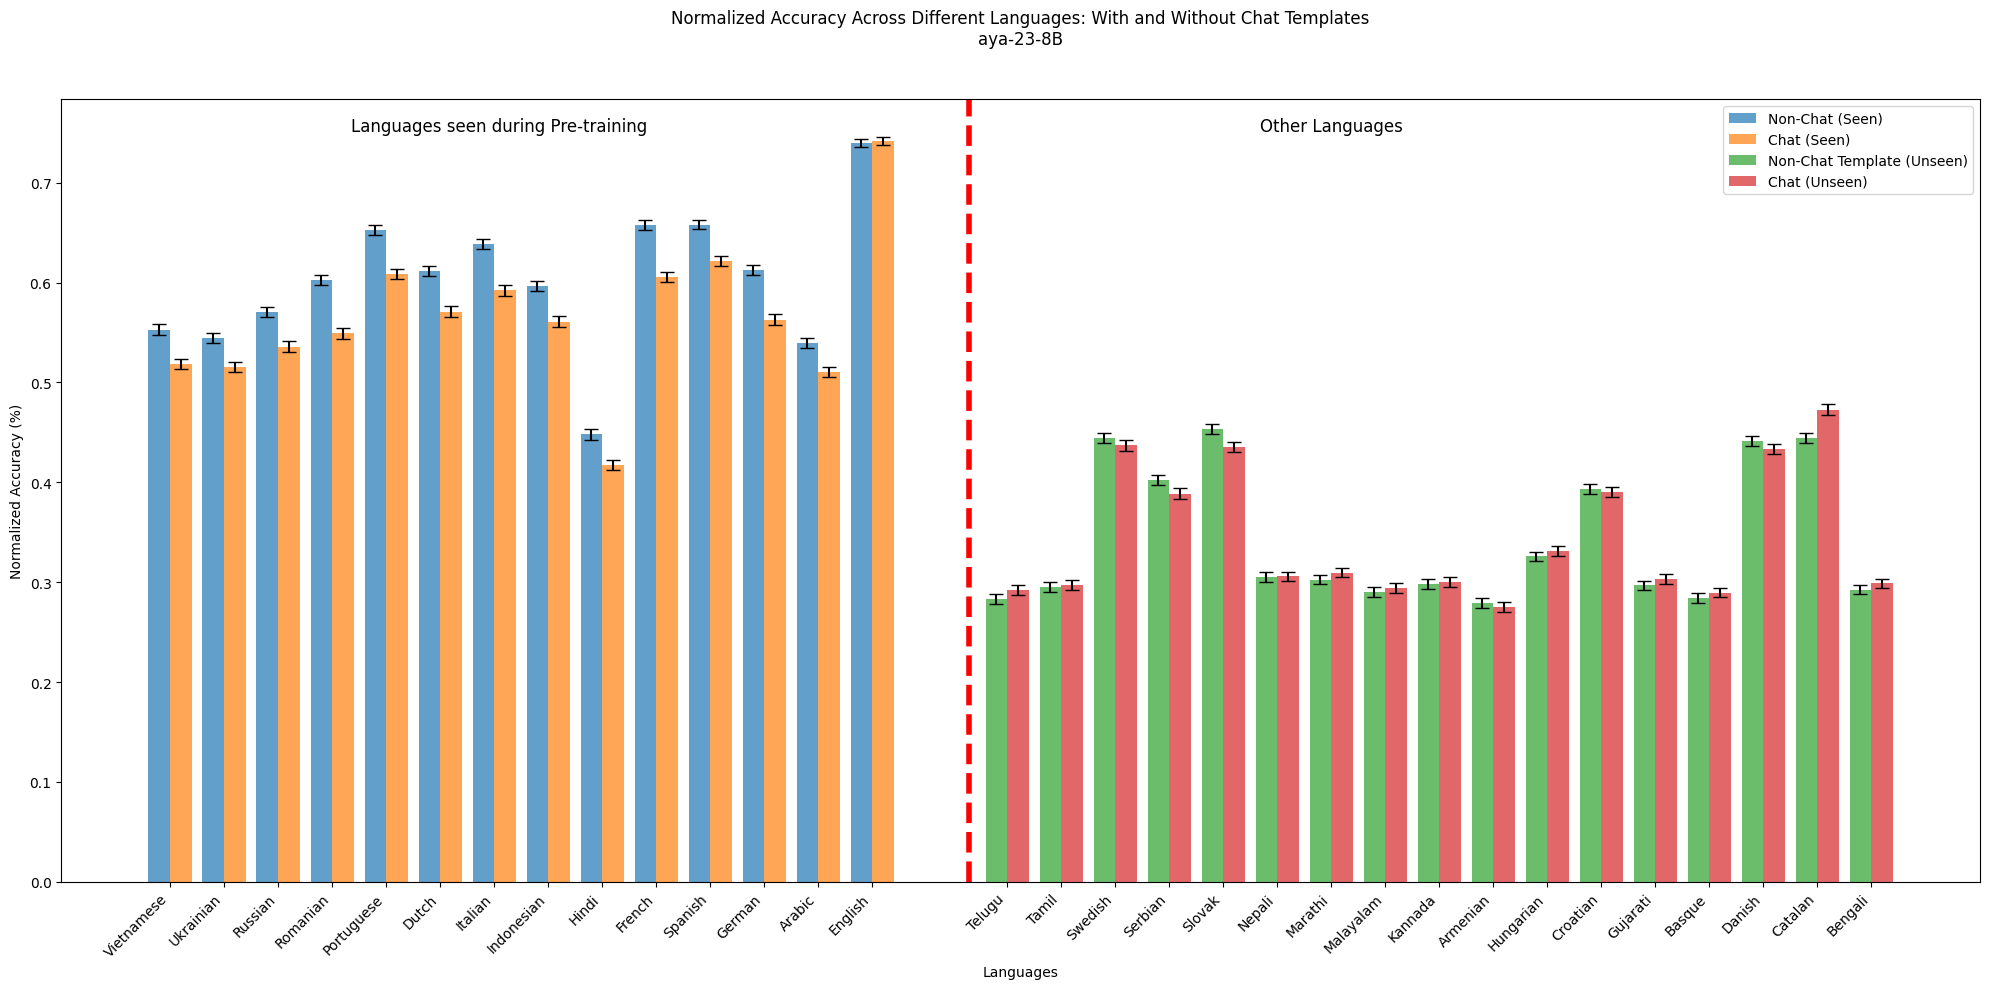

File already exists at ./input/results_2024-08-06T06-50-52_aya-23-35B-hellaswag_with_okapi_without_template_no_template.json
File already exists at ./input/results_2024-08-06T07-40-36_aya-23-35B-hellaswag_with_okapi_with_template_with_template.json
Data saved to ./output/results.csv


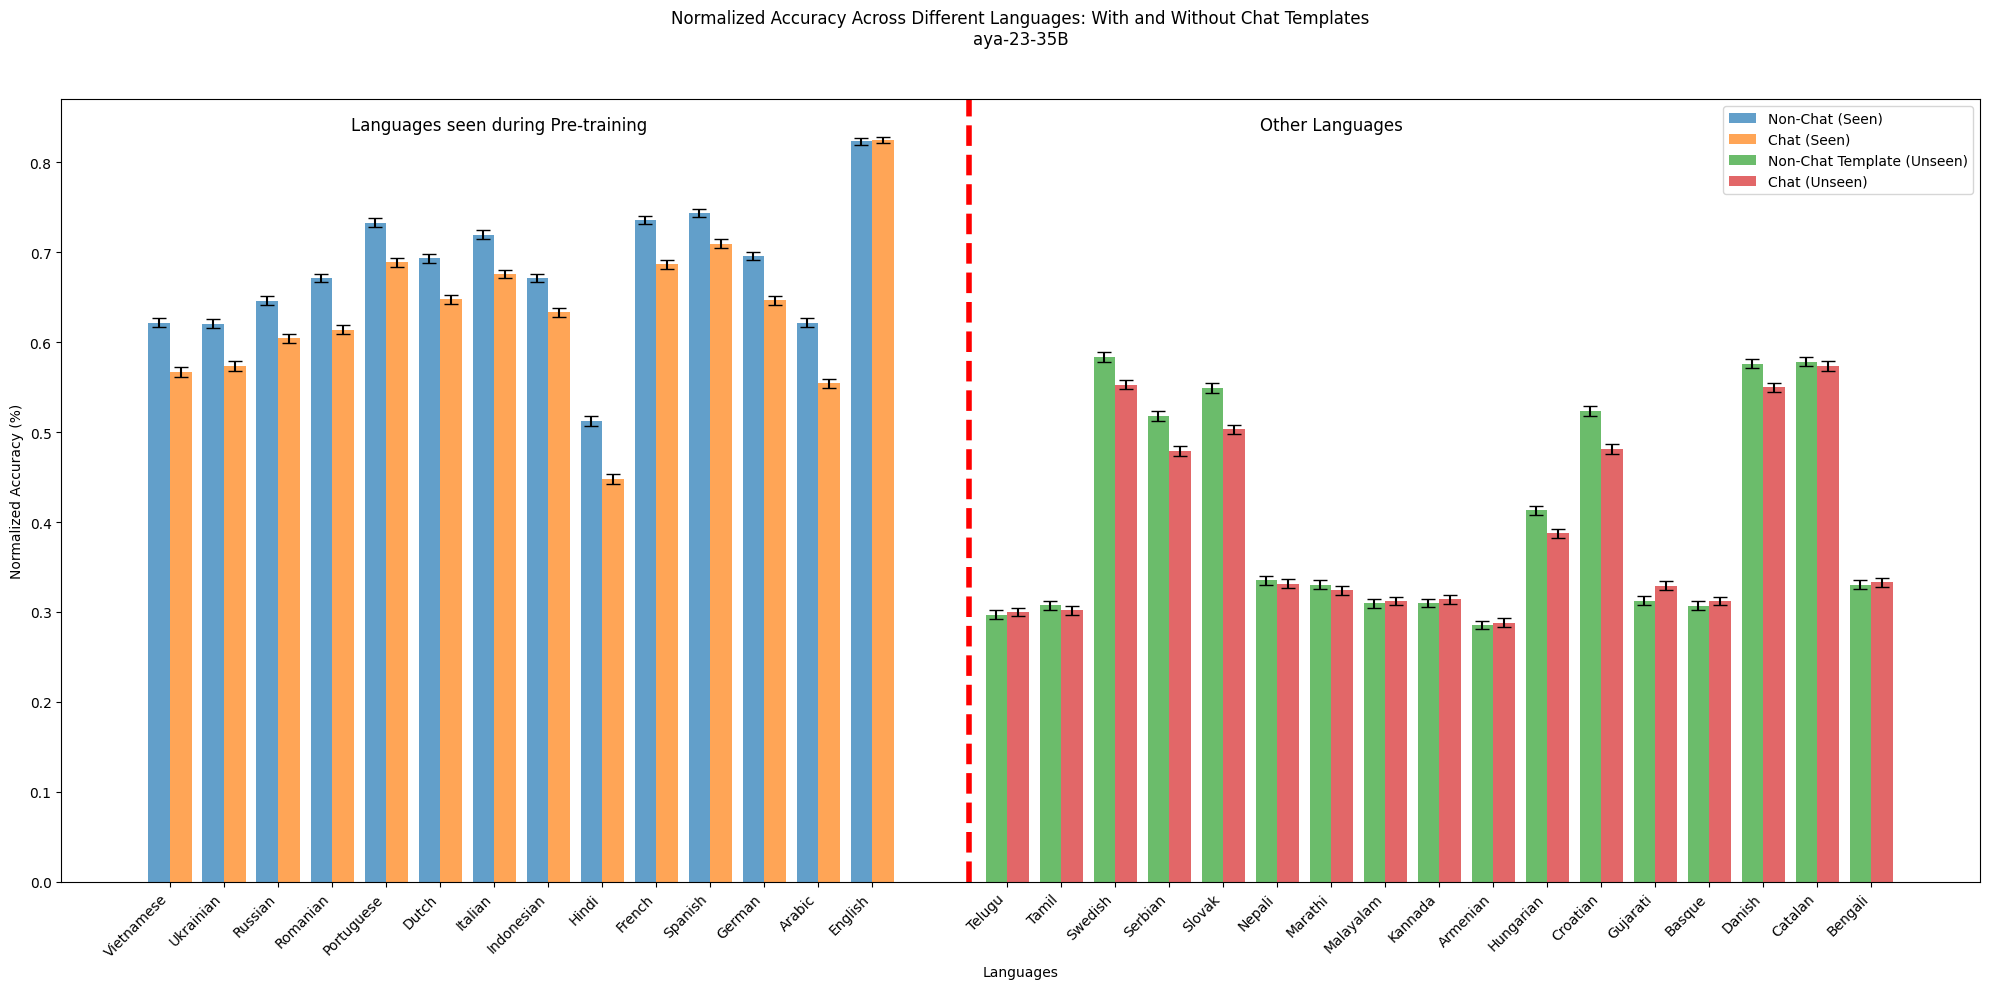

In [10]:
if __name__ == "__main__":
    # URLs and identifiers for different chat-template and non-chat template model pairs
    model_pairs = [
        {
            "non_chat_template": "https://github.com/aflah02/Perplexity-vs-Evaluation/raw/main/Experiments/LMEvalHarness_Runs/aya-23-8b-hellaswag_with_okapi_without_template/aya-23-8B/results_2024-08-04T14-52-52.186900.json",
            "chat_template": "https://github.com/aflah02/Perplexity-vs-Evaluation/raw/main/Experiments/LMEvalHarness_Runs/aya-23-8b-hellaswag_with_okapi_with_template/aya-23-8B/results_2024-08-04T22-30-16.191215.json",
            "model_name": "aya-23-8B"
        },
        {
            "non_chat_template": "https://github.com/aflah02/Perplexity-vs-Evaluation/raw/main/Experiments/LMEvalHarness_Runs/aya-23-35B-hellaswag_with_okapi_without_template/aya-23-35B/results_2024-08-06T06-50-52.427289.json",
            "chat_template": "https://github.com/aflah02/Perplexity-vs-Evaluation/raw/main/Experiments/LMEvalHarness_Runs/aya-23-35B-hellaswag_with_okapi_with_template/aya-23-35B/results_2024-08-06T07-40-36.390030.json",
            "model_name": "aya-23-35B"
        }
        # add more pairs here
    ]

    dest_base = "./input/"

    for pair in model_pairs:
        model_name = pair["model_name"]
        non_chat_dest = download_file(pair["non_chat_template"], dest_base, "no_template")
        chat_dest = download_file(pair["chat_template"], dest_base, "with_template")

        df_non_chat = parse_results_to_df([non_chat_dest])
        df_chat = parse_results_to_df([chat_dest])

        # Merge dataframes for plotting
        df = pd.merge(df_non_chat, df_chat, on='benchmark', suffixes=('_non_chat', '_chat'))

        # Save results to CSV
        save_results(df, 'csv')

        # Read the saved CSV
        df = pd.read_csv("./output/results.csv")

        # Plot results
        plot_results(df, model_name)
